In [78]:
from torch.utils.data import DataLoader, Dataset
from local_utils import Config, all_bipolar,four_bipolar, all_referential, two_referential, cut_and_jitter, build_montage
import numpy as np
import pandas as pd
import os
import pickle
import torch
from torchvision import transforms
import pytorch_lightning as pl
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm   

# load own code
import sys
sys.path.append('/home/moritz/Desktop/programming/epilepsy_project/')
from librarys.event.model.model import FineTuning
from librarys.event.datasets import SpikeDataset
from librarys.general.channel_lists import CDAC_mono_channels
from librarys.general.montages import build_montagev2
from librarys.event.transforms import cut_and_jitter,delete_channels
# this holds all the configuration parameters

In [79]:
class MultiSourceSpikeDataset(Dataset):
    def __init__(self, df, metadata, montage_channels, windowcutter = None,transform=None,normalize=False,echo=True):
        
        if echo: print(f'building dataset from {metadata.keys()}')
        # set lookup table
        self.df = df
        # set metadata
        self.metadata = metadata
        # set transform
        self.transform = transform
        # set windowcutter
        self.windowcutter = windowcutter
        # set normalize
        self.normalize = normalize
        if echo:
            if self.normalize: print('Dataloader normalizes!\n')
            else: print('Dataloader does not normalize!\n')

        # generate montages for all datasets
        self.montages = {}
        for dataset in metadata.keys():
            if echo: print('build montage for dataset ' + dataset + ' ...')
            montage = build_montage(storage_channels=metadata[dataset]['storage_channels'], 
                                                      montage_channels= montage_channels,
                                                      echo=echo)
            self.montages[dataset] = montage
    def __len__(self):
        return len(self.df)

    def _dataset_specific_loading_and_montage(self,event_file,dataset):
        path_signal = os.path.join(self.metadata[dataset]['path'],event_file+'.npy')
        signal = np.load(path_signal)
        signal = self.montages[dataset](signal)    
        return signal
    
    def _preprocess(self,signal):
        # cut window to desired shape
        if self.windowcutter is not None:
            signal = self.windowcutter(signal)
        # apply transformations
        if self.transform is not None:
            signal = self.transform(signal)                
        # normalize signal
        if self.normalize==True:
            signal = signal / (np.quantile(np.abs(signal), q=0.95, method="linear", axis=-1, keepdims=True) + 1e-8)
        # convert to torch tensor
        # replace nan values with 0
        signal = np.nan_to_num(signal)
        signal = torch.FloatTensor(signal.copy())
        
        return signal

    def __getitem__(self, idx):
        # get name and label of the idx-th sample
        event_file = self.df.iloc[idx]['event_file']
        label = self.df.iloc[idx]['fraction_of_yes']
        # get dataset specific information
        dataset = self.df.iloc[idx]['dataset']

        # load signal of the idx-th sample
        signal =self._dataset_specific_loading_and_montage(event_file,dataset)
        # preprocess signal
        signal = self._preprocess(signal)
        # return signal    
        return signal,label
        


In [80]:
class DeletedChannelsDatamoduleWithMembers(pl.LightningDataModule):
    def __init__(self,df,metadata,storage_channels,montage_channels,windowsize,windowjitter,Fq,batch_size,n_keeper_channels='random',keeper_channels='random',echo=True):
        super().__init__()
        self.df = df
        self.batch_size = batch_size

        if echo:
            print('building datamodule!')
            print(f'there are {len(df[df.Mode=="Train"])} test samples and {len(df[df.Mode=="Val"])} val samples')
            print(f'the fraction of positive samples is {df.fraction_of_yes.sum()/len(df):.2f}\n')

        channel_deleter = choose_channel_deleter(n_keeper_channels,montage_channels,keeper_channels)        
        # build deleter into dataset as a transformation!
        transforms_all = transforms.Compose([channel_deleter])

        # build montage and windowcutter
        windowcutter = cut_and_jitter(windowsize=windowsize,max_offset=windowjitter,Fq=Fq)

        self.dataset_train = MultiSourceSpikeDataset(df=self.df[self.df.Mode=='Train'],metadata = metadata,montage_channels=montage_channels, windowcutter = windowcutter,transform=transforms_all,normalize=True,echo=False)
        self.dataset_val = MultiSourceSpikeDataset(df=self.df[self.df.Mode=='Val'],metadata = metadata,montage_channels=montage_channels, windowcutter = windowcutter,transform=transforms_all,normalize=True,echo=False)    
        self.dataset_test = MultiSourceSpikeDataset(df=self.df[self.df.Mode=='Test'],metadata = metadata,montage_channels=montage_channels, windowcutter = windowcutter,transform=transforms_all,normalize=True,echo=False)
       
    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=os.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False, num_workers=os.cpu_count())

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False, num_workers=os.cpu_count())



In [81]:
path_model = '../Models/generalized_ten-twenty-rep'
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)

In [82]:
# load dataset
path_signal = '/media/moritz/a80fe7e6-2bb9-4818-8add-17fb9bb673e1/Data/Bonobo/cluster_center/'
df = pd.read_csv('/home/moritz/Desktop/programming/epilepsy_project/tables/bonobo/lut_event_23-08-22.csv')# fraction filter
extreme_quality_filter = df['total_votes_received'] >= 8

# test_df = df[frac_filter & mode_filter & extreme_quality_filter].copy()    
# neg = test_df[test_df.fraction_of_yes<0.5]         
# pos = test_df[test_df.fraction_of_yes>0.5][:len(neg)]
# test_df = pd.concat([neg,pos])

pos_auc_df = df[(df.Mode=='Test')&(df['fraction_of_yes'] >= /8) & extreme_quality_filter]
neg_auc_df = df[(df.Mode=='Test')&(df.fraction_of_yes==0)][:len(pos_auc_df)]
test_df = pd.concat([pos_auc_df,neg_auc_df])

In [83]:
# load pretrained model
model = FineTuning.load_from_checkpoint(path_model+'/weights.ckpt',
                                        lr=config.LR,
                                        head_dropout=config.HEAD_DROPOUT,
                                        n_channels=len(config.CHANNELS),
                                        n_fft=config.N_FFT,
                                        hop_length=config.HOP_LENGTH)
                                    
# init trainer
trainer = pl.Trainer(fast_dev_run=False,enable_progress_bar=False,devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [84]:
montage = build_montagev2(storage_channels=CDAC_mono_channels,montage_channels=config.CHANNELS)

storage channels: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']
montage channels: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']


# delete n random channels

In [85]:
def init_datamodule_info():
    datasets = {'center':dataset_center}
    df,metadata = prepare_member_and_center_info(datasets)
    storage_channels = all_referential
    return df, metadata, storage_channels



In [86]:
def dataset_center():
    # returns high confidence dataframe, path and storage channels
    # Load Bonobo dataframe and add 'dataset' column
    #df = pd.read_csv('../Data/tables/lut_event_23-08-22.csv')
    df = pd.read_csv('../Data/tables/event_split_localized_08Feb24.csv')
    df['dataset'] = 'center' 
    df = df[(df.total_votes_received>=3)|(df.fraction_of_yes==0)]
    path = '/media/moritz/a80fe7e6-2bb9-4818-8add-17fb9bb673e1/Data/Bonobo/cluster_center/' 
    storage_channels = all_referential

    return df, path, storage_channels



In [87]:

def prepare_member_and_center_info(datasets):
    # input: list of dataset functions, each of which returns the datasets dataframe, location and storage chanel
    # output: concatenated_dataframes + metadata dictionary
    # Initialize empty list to collect dataframes
    dfs = []
    # Create empty dictionary to store dataset metadata
    metadata = {}

    

    for dataset in datasets.keys():
        datasets[dataset]()
        df, path, storage_channels = datasets[dataset]()
        dfs.append(df)
        metadata[dataset]={}
        metadata[dataset]['path']=path
        metadata[dataset]['storage_channels']=storage_channels

    df = pd.concat(dfs)
    df = df[['event_file','patient_id','total_votes_received','fraction_of_yes','Mode','dataset']]

    print(f'\n using the following datasets: {metadata.keys()} to build datamodule\n')
    # print how much data each dataset has
    print(df.dataset.value_counts())
    return df, metadata


In [88]:
def apply_filters(df):
    pos = df[(df['fraction_of_yes'] >= 7/8) & (df.total_votes_received >=8) &(df.Mode=='Test')]
    neg = df[(df.fraction_of_yes==0)&(df.Mode=='Test')]
    N = min(len(pos),len(neg))
    print(N)
    df = pd.concat([pos[:N],neg[:N]])    
    return df

In [89]:
df, metadata, storage_channels = init_datamodule_info()
df = apply_filters(df)


 using the following datasets: dict_keys(['center']) to build datamodule

center    30394
Name: dataset, dtype: int64
1167


In [90]:
def choose_channel_deleter(n_keeper_channels,montage_channels,keeper_channels):
    # choose right channel deleter dependent on what type is desired
    if n_keeper_channels=='random':
        print('keeping random number of random channels!\n')
        channel_deleter = keep_random_number_of_random_channels(montage_channels=montage_channels)
    elif (n_keeper_channels!='random')&(keeper_channels=='random'):
        print(f'keeping {n_keeper_channels} random channels\n')
        channel_deleter = keep_fixed_number_of_random_channels(montage_channels=montage_channels,n_keeper_channels=n_keeper_channels)
    elif (n_keeper_channels!='random')&(keeper_channels!='random'):
        print(f'keeping the following channels: {keeper_channels}!\n')
        channel_deleter = keep_fixed_number_of_fixed_channels(montage_channels=montage_channels,keeper_channels=keeper_channels)

    return channel_deleter


In [91]:
    
class keep_fixed_number_of_random_channels():
    # init with list of signal montage channels, number of channels to be retained
    # use: input: signal
    # output: zero masked signal with *fixed* number of random channels retained
    def __init__(self,montage_channels,n_keeper_channels):
        self.n_channels = len(montage_channels)
        self.n_keeper_channels = n_keeper_channels
    def __call__(self,signal):
        # choose n random keeper_channels
        keeper_indices = np.random.choice(self.n_channels, self.n_keeper_channels, replace=False)
        # build output
        output = np.zeros_like(signal)
        output[keeper_indices,:] = signal[keeper_indices,:]
        return output


In [93]:
results = {'n_keeper':[],'run':[],'AUC':[]} # store results here

# get labels and convert them to binary labels (0.1 -> 0, 0.9 -> 1)
labels = df.fraction_of_yes.round(0).astype(int)

for n_keeper in tqdm(range(0,len(config.CHANNELS)+1)):
    print(f'Running for {n_keeper} kept channels')
    datamodule = DeletedChannelsDatamoduleWithMembers(df=df,
                                                  storage_channels=all_referential,
                                                  montage_channels=config.CHANNELS,
                                                  Fq=config.FQ,
                                                  metadata=metadata,
                                                  windowsize=config.WINDOWSIZE,
                                                  windowjitter=config.WINDOWJITTER,
                                                  batch_size=config.BATCH_SIZE,
                                                  n_keeper_channels=n_keeper,
                                                  keeper_channels='random')
    # predict on AUC dataset n times, as channel deletion is random
    for run in range(5):
        preds = trainer.predict(model,datamodule.test_dataloader())
        preds = np.concatenate(preds)
        
        fpr, tpr, thresholds = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)

        results['n_keeper'].append(n_keeper)
        results['run'].append(run)
        results['AUC'].append(roc_auc)

  0%|          | 0/20 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 0 kept channels
building datamodule!
there are 0 test samples and 0 val samples
the fraction of positive samples is 0.47

keeping 0 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
  5%|▌         | 1/20 [00:10<03:26, 10.84s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 1 kept channels
building datamodule!
there are 0 test samples and 0 val samples
the fraction of positive samples is 0.47

keeping 1 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 10%|█         | 2/20 [00:21<03:16, 10.91s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 2 kept channels
building datamodule!
there are 0 test samples and 0 val samples
the fraction of positive samples is 0.47

keeping 2 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 15%|█▌        | 3/20 [00:32<03:05, 10.90s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 3 kept channels
building datamodule!
there are 0 test samples and 0 val samples
the fraction of positive samples is 0.47

keeping 3 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 20%|██        | 4/20 [00:43<02:54, 10.90s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 4 kept channels
building datamodule!
there are 0 test samples and 0 val samples
the fraction of positive samples is 0.47

keeping 4 random channels



In [58]:
class MultiSourceSpikeDataset(Dataset):
    def __init__(self, df, metadata, montage_channels, windowcutter = None,transform=None,normalize=False,echo=True):
        
        if echo: print(f'building dataset from {metadata.keys()}')
        # set lookup table
        self.df = df
        # set metadata
        self.metadata = metadata
        # set transform
        self.transform = transform
        # set windowcutter
        self.windowcutter = windowcutter
        # set normalize
        self.normalize = normalize
        if echo:
            if self.normalize: print('Dataloader normalizes!\n')
            else: print('Dataloader does not normalize!\n')

        # generate montages for all datasets
        self.montages = {}
        for dataset in metadata.keys():
            if echo: print('build montage for dataset ' + dataset + ' ...')
            montage = build_montage(storage_channels=metadata[dataset]['storage_channels'], 
                                                      montage_channels= montage_channels,
                                                      echo=echo)
            self.montages[dataset] = montage
    def __len__(self):
        return len(self.df)

    def _dataset_specific_loading_and_montage(self,event_file,dataset):
        path_signal = os.path.join(self.metadata[dataset]['path'],event_file+'.npy')
        signal = np.load(path_signal)
        signal = self.montages[dataset](signal)    
        return signal
    
    def _preprocess(self,signal):
        # cut window to desired shape
        if self.windowcutter is not None:
            signal = self.windowcutter(signal)
        # apply transformations
        if self.transform is not None:
            signal = self.transform(signal)                
        # normalize signal
        if self.normalize==True:
            signal = signal / (np.quantile(np.abs(signal), q=0.95, method="linear", axis=-1, keepdims=True) + 1e-8)
        # convert to torch tensor
        # replace nan values with 0
        signal = np.nan_to_num(signal)
        signal = torch.FloatTensor(signal.copy())
        
        return signal

    def __getitem__(self, idx):
        # get name and label of the idx-th sample
        event_file = self.df.iloc[idx]['event_file']
        label = self.df.iloc[idx]['fraction_of_yes']
        # get dataset specific information
        dataset = self.df.iloc[idx]['dataset']

        # load signal of the idx-th sample
        signal =self._dataset_specific_loading_and_montage(event_file,dataset)
        # preprocess signal
        signal = self._preprocess(signal)
        # return signal    
        return signal,label
        

NameError: name 'Dataset' is not defined

In [59]:
deletion_results = pd.DataFrame(results)
deletion_results.to_csv(path_model+'deletion_results.csv',index=False)

ValueError: 'x' and 'y' must have the same size

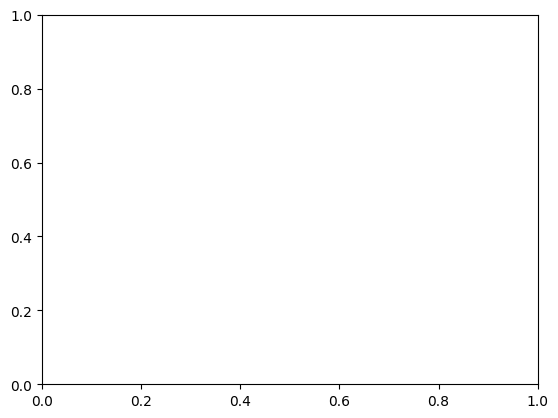

In [60]:
auc_value = pd.DataFrame(results).groupby('n_keeper')['AUC'].mean()
err = pd.DataFrame(results).groupby('n_keeper')['AUC'].std()
# plt.plot(range(0,20),auc)
plt.errorbar(range(0,20),auc_value,yerr=err)
plt.xticks(range(0,20))
plt.yticks(np.arange(0.5,1.01,1/20))
plt.tight_layout()
plt.ylabel('easyAUC')
plt.xlabel('n channels retained')
plt.title(f'random channels retained, n = {len(test_df)}')
plt.grid(alpha=0.3)
plt.tight_layout()

In [ ]:
np.arange(0.5,1,1/20)

In [ ]:
test_df[test_df.fraction_of_yes<0.5]